# all scores scikit-learn - overfitting example :) 

## In this notebook:

* single input dataframe 
* using all scores: dropping missing data
* model: random forest and SVM
* only training/test split, no epochs 
* aucuracy assessement of 1.00 LOL 

In [23]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


df = pd.read_csv('../data/chr20_out_scores.tsv', sep='\t', encoding = "UTF-8")
df = df.set_index(['chr','pos', 'ref', 'alt']) #index by identifier
#print(df.to_string()) ## will print the whole dataframe
#df.plot.hist()
df.head()
#print(df.head())
print("shape before", df.shape)
df = df.replace({'.': np.nan})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

df.head()
df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

print("shape after dropping Unk", df.shape)
#df.head()

shape before (3337, 28)
SUM SIFT_score                  1222
SIFT4G_score                 554
Polyphen2_HDIV_score        1314
Polyphen2_HVAR_score        1413
LRT_score                    337
MutationTaster_score           3
MutationAssessor_score      1547
FATHMM_score                1353
PROVEAN_score               1298
VEST4_score                  867
MetaSVM_score                404
MetaLR_score                 404
M-CAP_score                  630
REVEL_score                  404
MutPred_score               1536
MVP_score                    719
MPC_score                   2373
PrimateAI_score              474
DEOGEN2_score               1679
DANN_score                     0
fathmm-MKL_coding_score        0
fathmm-XF_coding_score       115
GenoCanyon_score               0
integrated_fitCons_score       0
GM12878_fitCons_score          0
H1-hESC_fitCons_score          0
HUVEC_fitCons_score            0
clinvar_clnsig                 8
dtype: int64
shape after dropping all data with 

In [24]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                     SIFT_score SIFT4G_score Polyphen2_HDIV_score  \
chr pos      ref alt                                                
20  63361125 G   A        0.722        0.652                  0.0   
    10673469 A   G        0.015        0.064                0.984   
    33412714 G   A        0.034        0.122                0.999   

                     Polyphen2_HVAR_score LRT_score MutationTaster_score  \
chr pos      ref alt                                                       
20  63361125 G   A                    0.0  0.039676             0.999598   
    10673469 A   G                  0.979  0.000009             0.999999   
    33412714 G   A                  0.675  0.000047                    1   

                     MutationAssessor_score FATHMM_score PROVEAN_score  \
chr pos      ref alt                                                     
20  63361125 G   A                    1.795         -1.0          0.97   
    10673469 A   G           

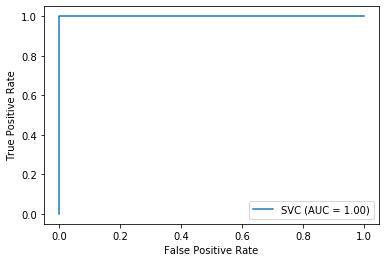

y true [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
y predicted [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Confusion matrix: 
 [[ 1  0]
 [ 0 19]]
Accuracy: 1.0
Recall TP/(TP+FN): [1. 1.]
Precision TP/(TP+FP): [1. 1.]
F1: [1. 1.]


In [25]:
## Try a binary support vector machine:

classifier1 = SVC(kernel='rbf', gamma='scale',random_state=42) # default for kernel and gamma. AUC = 0.94
classifier2 = SVC(kernel='linear', gamma=10 ,random_state=42) # 0.94
classifier3 = SVC(kernel='sigmoid', gamma=10 ,random_state=42) # 0.82

classifier1.fit(df_train, train_labels)
svc_disp = plot_roc_curve(classifier1, df_test, test_labels)
plt.show()


### Run some stats to see if the model is doing well. 
### Note: for chr20, there are 696 exampels that pass, meaning 25% used for testing gives low numbers, see cm
y_true = test_labels.to_numpy()
y_pred = classifier1.predict(df_test)


print("y true", y_true) ## These are both numpy arrays now, why are the metrics returning arrays rather than single f
print("y predicted", y_pred)

## see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

In [26]:
#type(y_true.to_numpy())  # pandas.core.series.Series
#type(y_pred) # numpy.ndarray

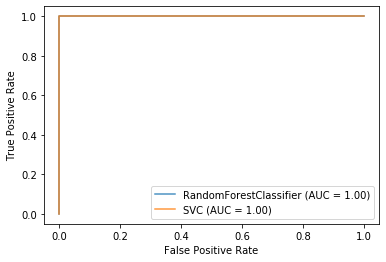

Accuracy: 0.95
Confusion matrix: 
 [[ 1  0]
 [ 1 18]]
Feature ranking:
1. feature 0 (0.226391)
2. feature 4 (0.165331)
3. feature 1 (0.122647)
4. feature 20 (0.099664)
5. feature 21 (0.088343)
6. feature 19 (0.075593)
7. feature 23 (0.049851)
8. feature 8 (0.026357)
9. feature 11 (0.025159)
10. feature 24 (0.023485)
11. feature 22 (0.021231)
12. feature 14 (0.020357)
13. feature 9 (0.016748)
14. feature 6 (0.011795)
15. feature 25 (0.006513)
16. feature 3 (0.006381)
17. feature 7 (0.005019)
18. feature 12 (0.004966)
19. feature 2 (0.002280)
20. feature 13 (0.001889)
21. feature 10 (0.000000)
22. feature 5 (0.000000)
23. feature 15 (0.000000)
24. feature 16 (0.000000)
25. feature 17 (0.000000)
26. feature 18 (0.000000)
27. feature 26 (0.000000)


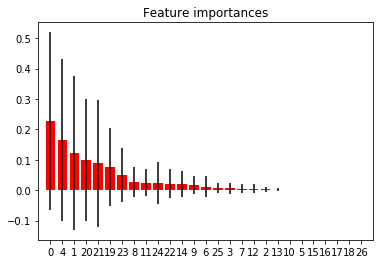

In [27]:
# Try a random forest:

forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)
print("Accuracy:", accuracy_score(y_true, y_pred))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))


## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), indices)
plt.xlim([-1, df_train.shape[1]])
plt.show()